In [15]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
# necessary libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime

# for building neural networks
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

# for hyperparameter tuning
!pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# for metric calculation
from sklearn.metrics import confusion_matrix

# for interpretability
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from PIL import Image

E0326 18:46:37.585820915      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


E0326 18:46:49.716412301      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


In [17]:
# reading the training data csv file
train_csv = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
train_csv

,Filename,Label
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0
...,...,...
7555,7556.png,3
7556,7557.png,3
7557,7558.png,3
7558,7559.png,3


In [18]:
# create a custom Dataset for the cancer cell images
class CancerCellDataset(Dataset):
    
    def __init__(self,csv,root_dir,transform=None):
        self.train_csv = pd.read_csv(csv)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self): # returns the length of the dataset
        return len(self.train_csv) 
    
    def __getitem__(self,idx): # returns every data item of the dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.train_csv.iloc[idx,0])
        image = io.imread(img_name)
        label = self.train_csv.iloc[idx,1]
        label = np.array(label)
        sample = {'image':image,'label':label,'idx':idx} # comprises of the image, its label and its index in the csv file
        
        if self.transform: # applying transforms if any
            sample = self.transform(sample)
        
        return sample

In [19]:
class ToTensor(object):
    
    def __call__(self,sample):
        image,label = sample['image'],sample['label']
        image = image.transpose((2,0,1))
        return {'image':torch.from_numpy(image).to(torch.float32),
               'label':torch.from_numpy(label),'idx':sample['idx']}

In [20]:
# train-validation splitting
cancer_dataset = CancerCellDataset(csv='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                  root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                  transform = transforms.Compose([ToTensor()]))
train_size = int(0.8 * len(cancer_dataset))
val_size = len(cancer_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(cancer_dataset, [train_size, val_size])

In [21]:
epoch_print_gap = 1

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, val_loader):
    model.train()
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        for batch_num,sample in enumerate(train_loader):
            outputs = model(sample['image'].to(device)) # get the outputs from the model
            loss = loss_fn(outputs, sample['label'].to(device)) # calculate loss w.r.t original outputs
            
            optimizer.zero_grad() #clears the existing gradients for the current epoch
            loss.backward() #backward propagation - differentiation of loss w.r.t neural net parameters
            optimizer.step() #updates the weights : weight = weight - lr * gradient (dL/dw)
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            test_loop(epoch,model,device,train_loader,val_loader,loss_fn,optimizer)

def test_loop(epoch, model, device, train_loader, val_loader, loss_fn, optimizer):
    model.eval()
    model = model.to(device)
    print('-----------------------------------Epoch '+str(epoch)+' ----------------------------\n')
    '''training data loss and accuracy'''
    train_loss = 0
    correct = 0
    
    with torch.no_grad(): #deactivates gradient computation since we are evaluating the model
        for batch_num, sample in enumerate(train_loader):
            data, target = sample['image'].to(device), sample['label'].to(device)
            output = model(data)
            train_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    
    training_loss.append(train_loss)
    training_accuracy.append(correct / len(train_loader.dataset))
    
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    
    '''validation data loss and accuracy'''
    val_loss = 0
    correct = 0
    
    with torch.no_grad(): #deactivates gradient computation since we are evaluating the model
        for batch_num, sample in enumerate(val_loader):
            data, target = sample['image'].to(device), sample['label'].to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    
    validation_loss.append(val_loss)
    validation_accuracy.append(correct / len(val_loader.dataset))
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    tune.report(loss=val_loss, accuracy=correct / len(val_loader.dataset)) # reporting validation loss and accuracy using ray-tune

# Model 1 - own Convolutional Neural Network (CNN)

My model comprises of 7 layers in total - 3 Conv2D layers and 4 fully-connected layers. 
The outputs of each layer are passed through ReLU activation to prevent the vanishing-gradient problem. 
l1, l2, l3 i.e. the no. of neurons in each fully-connected layer, and num_outputs i.e. the no. of labels can be varied

In [41]:
class ConvNet(nn.Module):
    
    def __init__(self,num_outputs,l1,l2,l3):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12800,l1)
        self.fc2 = nn.Linear(l1,l2)
        self.fc3 = nn.Linear(l2,l3)
        self.fc4 = nn.Linear(l3,num_outputs)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [42]:
def train_ConvNet(config):
    net = ConvNet(len(train_csv.iloc[:,1].unique()),config["l1"], config["l2"], config["l3"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device) #assigning neural network to whichever device is available - cpu, gpu or multiple gpus

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    val_dataloader = DataLoader(
        val_dataset)

    n_epochs = 50

    training_loop(n_epochs,optimizer,net,device,criterion,train_dataloader, val_dataloader)
    print("Finished Training")

### Hyperparameter Tuning

In [43]:
num_samples = 10 # no. of hyperparameter sets to test
max_num_epochs = 2 # no. of training iteration per hyperparameter set
gpus_per_trial = 2

# hyperparameter search space
config = {
    'l1':tune.sample_from(lambda _: 2 ** np.random.randint(7,8+1)),
    'l2':tune.sample_from(lambda _: 2 ** np.random.randint(5,6+1)),
    'l3':tune.sample_from(lambda _: 2 ** np.random.randint(3,4+1)),
    'lr':tune.loguniform(1e-4,1e-2),
    'batch_size':tune.choice([16,32,64])
}
# scheduler for hyperparameter search
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

# reports the hyperparameter search results
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])

# running the hyperparameter search
result = tune.run(
        train_ConvNet,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

== Status ==
Current time: 2023-03-26 19:58:33 (running for 00:00:00.29)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|---------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_ConvNet_9658e_00000 | RUNNING  | 172.19.2.2:91503 |           64 |  128 |   32 |    8 | 0.00910277  |
| train_ConvNet_9658e_00001 | PENDING  |                  |           64 |  128 |   64 |    8 | 0.000134368 |
| train_ConvNet_9658e_0000

(train_ConvNet pid=91503) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=91503)   cpuset_checked))
(train_ConvNet pid=91503) E0326 19:58:41.141645138   91544 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=91503) E0326 19:58:41.281127627   91544 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 19:58:44 (running for 00:00:11.11)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|---------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_ConvNet_9658e_00000 | RUNNING  | 172.19.2.2:91503 |           64 |  128 |   32 |    8 | 0.00910277  |
| train_ConvNet_9658e_00001 | PENDING  |                  |           64 |  128 |   64 |    8 | 0.000134368 |
| train_ConvNet_9658e_0000

(train_ConvNet pid=91503) E0326 19:58:56.042699041   91544 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(train_ConvNet pid=91503) -----------------------------------Epoch 1 ----------------------------
(train_ConvNet pid=91503) 
== Status ==
Current time: 2023-03-26 19:58:59 (running for 00:00:26.15)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|---------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_ConvNet_9658e_00000 | RUNNING  | 172.19.2.2:91503 |           64 |  128 |   32 |    8 | 0.00910277  |
| train_Con

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_ConvNet_9658e_00000,0.621032,2023-03-26_19-59-38,True,,f744357eef4b416aa13025fe78b85b8d,410e8f9ac071,2,0.990124,172.19.2.2,91503,58.7988,24.9304,58.7988,1679860778,0,,2,9658e_00000,0.00878072
train_ConvNet_9658e_00001,0.795635,2023-03-26_20-00-41,True,,548ab4f479e64b12b9108152b60f020f,410e8f9ac071,2,0.673706,172.19.2.2,92743,57.7147,24.8932,57.7147,1679860841,0,,2,9658e_00001,0.00562215
train_ConvNet_9658e_00002,0.76455,2023-03-26_20-01-50,True,,fb05d40c445e4c62998667e4778a2a5c,410e8f9ac071,2,0.553782,172.19.2.2,93958,62.3307,27.3293,62.3307,1679860910,0,,2,9658e_00002,0.00557923
train_ConvNet_9658e_00003,0.835979,2023-03-26_20-02-55,True,,39051b9dbc2341d4b44f4d92a4aae443,410e8f9ac071,2,0.493486,172.19.2.2,95947,58.5184,25.5035,58.5184,1679860975,0,,2,9658e_00003,0.00865102
train_ConvNet_9658e_00004,0.825397,2023-03-26_20-04-00,True,,ea84442189494d579ab4a8b177960233,410e8f9ac071,2,0.497901,172.19.2.2,97174,58.1966,25.3646,58.1966,1679861040,0,,2,9658e_00004,0.00724578
train_ConvNet_9658e_00005,0.811508,2023-03-26_20-05-17,True,,e15651c770f743c699e07c524396e475,410e8f9ac071,2,0.462141,172.19.2.2,98408,70.4719,31.6459,70.4719,1679861117,0,,2,9658e_00005,0.00567341
train_ConvNet_9658e_00006,0.460317,2023-03-26_20-06-03,True,,38371106df9b4594b969d64589421acb,410e8f9ac071,1,1.3529,172.19.2.2,101922,39.2807,39.2807,39.2807,1679861163,0,,1,9658e_00006,0.00526237
train_ConvNet_9658e_00007,0.460317,2023-03-26_20-06-49,True,,bc410a7bbe2e4ea9bcf4b7d0d2bb81a5,410e8f9ac071,1,1.18054,172.19.2.2,103705,38.9356,38.9356,38.9356,1679861209,0,,1,9658e_00007,0.00549316
train_ConvNet_9658e_00008,0.343915,2023-03-26_20-07-29,True,,f7858bb9bd97440590d1b0def415f22e,410e8f9ac071,1,1.29905,172.19.2.2,105471,34.6082,34.6082,34.6082,1679861249,0,,1,9658e_00008,0.00615382
train_ConvNet_9658e_00009,0.820767,2023-03-26_20-08-47,True,,6ee160308583434f86121d023810a9f7,410e8f9ac071,2,0.462277,172.19.2.2,106492,71.2265,32.0183,71.2265,1679861327,0,,2,9658e_00009,0.00569963


(train_ConvNet pid=91503) 
(train_ConvNet pid=91503) Validation set: Average loss: 1.0895, Accuracy: 877/1512 (58%)
(train_ConvNet pid=91503) 
== Status ==
Current time: 2023-03-26 19:59:18 (running for 00:00:45.00)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: -1.0894615876354428
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+------+-------------+---------+------------+----------------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |    loss |   accuracy |   training_iteration |
|---------------------------+----------+------------------+--------------+------+------+------+-----------

(train_ConvNet pid=92743) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=92743)   cpuset_checked))
(train_ConvNet pid=92743) E0326 19:59:46.008637173   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 19:59:49 (running for 00:01:15.92)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.9901242198169218 | Iter 1.000: -1.0894615876354428
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00001 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=92743) E0326 20:00:00.480085275   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=92743) E0326 20:00:00.558650744   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=92743) E0326 20:00:00.595059312   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(train_ConvNet pid=92743) -----------------------------------Epoch 1 ----------------------------
(train_ConvNet pid=92743) 


(train_ConvNet pid=92743) E0326 20:00:00.722468530   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:00:04 (running for 00:01:30.98)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.9901242198169218 | Iter 1.000: -1.0894615876354428
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00001 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=92743) E0326 20:00:17.266131848   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:00:21 (running for 00:01:48.75)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.9901242198169218 | Iter 1.000: -0.9993951277826609
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00001 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=92743) E0326 20:00:26.385488042   92782 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:00:27 (running for 00:01:53.79)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.9901242198169218 | Iter 1.000: -0.9993951277826609
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00001 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=93958) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=93958)   cpuset_checked))
(train_ConvNet pid=93958) E0326 20:00:49.828816684   93998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=93958) E0326 20:00:49.939327541   93998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:00:53 (running for 00:02:19.84)
Memory usage on this node: 7.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: -0.8319153131251955 | Iter 1.000: -0.9993951277826609
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00002 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=93958) E0326 20:01:06.064507085   93998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:01:08 (running for 00:02:34.89)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: -0.8319153131251955 | Iter 1.000: -0.9993951277826609
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00002 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=95947) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=95947)   cpuset_checked))
(train_ConvNet pid=95947) E0326 20:01:58.987222731   95987 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:02:02 (running for 00:03:28.87)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 2.000: -0.6737064064334691 | Iter 1.000: -0.909328667929879
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00003 | RUNNING    | 172.19.2.2:95

(train_ConvNet pid=95947) E0326 20:02:14.527843309   95987 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:02:17 (running for 00:03:43.91)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 2.000: -0.6737064064334691 | Iter 1.000: -0.909328667929879
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00003 | RUNNING    | 172.19.2.2:95

(train_ConvNet pid=95947) E0326 20:02:30.117469887   95987 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=95947) E0326 20:02:30.158640265   95987 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(train_ConvNet pid=95947) 
(train_ConvNet pid=95947) Validation set: Average loss: 0.7127, Accuracy: 1119/1512 (74%)
(train_ConvNet pid=95947) 
== Status ==
Current time: 2023-03-26 20:02:35 (running for 00:04:01.91)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 2.000: -0.6737064064334691 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+---------

(train_ConvNet pid=95947) E0326 20:02:39.345432137   95987 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(train_ConvNet pid=95947) -----------------------------------Epoch 2 ----------------------------
(train_ConvNet pid=95947) 
== Status ==
Current time: 2023-03-26 20:02:40 (running for 00:04:06.92)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 2.000: -0.6737064064334691 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------

(train_ConvNet pid=97174) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=97174)   cpuset_checked))
(train_ConvNet pid=97174) E0326 20:03:03.856120350   97216 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:03:07 (running for 00:04:33.85)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 2.000: -0.6137439850577429 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00004 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=97174) E0326 20:03:19.176502877   97216 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=97174) E0326 20:03:19.259236969   97216 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:03:22 (running for 00:04:48.91)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 2.000: -0.6137439850577429 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00004 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=97174) E0326 20:03:44.422408057   97216 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:03:44 (running for 00:05:11.70)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 2.000: -0.6137439850577429 | Iter 1.000: -0.8291273970321984
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00004 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=98408) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=98408)   cpuset_checked))
(train_ConvNet pid=98408) E0326 20:04:09.102986518   98449 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:04:12 (running for 00:05:38.84)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 2.000: -0.5537815636820167 | Iter 1.000: -0.8291273970321984
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00005 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=98408) E0326 20:04:45.889072190   98449 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=98408) E0326 20:04:46.142858067   98449 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:04:50 (running for 00:06:17.66)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 2.000: -0.5537815636820167 | Iter 1.000: -0.7708952629553567
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00005 | RUNNING    | 172.19.2.2:9

(train_ConvNet pid=101922) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=101922)   cpuset_checked))
(train_ConvNet pid=101922) E0326 20:05:26.480056639  101964 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=101922) E0326 20:05:26.550438331  101964 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:05:29 (running for 00:06:56.42)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.7708952629553567
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00006 | RUNNING    | 172.19.2.

(train_ConvNet pid=101922) E0326 20:05:45.312411666  101964 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:05:49 (running for 00:07:16.48)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.7708952629553567
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00006 | RUNNING    | 172.19.2.

(train_ConvNet pid=103705) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=103705)   cpuset_checked))
(train_ConvNet pid=103705) E0326 20:06:11.952659320  103746 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=103705) E0326 20:06:11.998677127  103746 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=103705) E0326 20:06:12.022501016  103746 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_Con

== Status ==
Current time: 2023-03-26 20:06:15 (running for 00:07:41.88)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.8291273970321984
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00007 | RUNNING    | 172.19.2.

(train_ConvNet pid=103705) E0326 20:06:31.473772914  103746 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:06:35 (running for 00:08:01.95)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.8291273970321984
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00007 | RUNNING    | 172.19.2.

(train_ConvNet pid=105471) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=105471)   cpuset_checked))
(train_ConvNet pid=105471) E0326 20:06:56.955660760  105511 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:07:00 (running for 00:08:26.94)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00008 | RUNNING    | 172.19.2.

(train_ConvNet pid=105471) E0326 20:07:13.604663720  105511 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=105471) E0326 20:07:13.665006592  105511 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:07:15 (running for 00:08:41.98)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00008 | RUNNING    | 172.19.2.

(train_ConvNet pid=106492) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(train_ConvNet pid=106492)   cpuset_checked))
(train_ConvNet pid=106492) E0326 20:07:38.298952045  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=106492) E0326 20:07:38.435003699  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:07:41 (running for 00:09:08.23)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.909328667929879
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00009 | RUNNING    | 172.19.2.2:106492 |  

(train_ConvNet pid=106492) E0326 20:07:57.091859343  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=106492) E0326 20:07:57.209467267  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=106492) E0326 20:07:57.292357012  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_ConvNet pid=106492) E0326 20:07:57.335519423  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:08:01 (running for 00:09:28.29)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.909328667929879
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00009 | RUNNING    | 172.19.2.2:106492 |  

(train_ConvNet pid=106492) E0326 20:08:28.959914691  106531 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 20:08:30 (running for 00:09:57.48)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5258411035519676 | Iter 1.000: -0.8692280324810386
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_ConvNet_9658e_00009 | RUNNING    | 172.19.2.2:106492 | 

2023-03-26 20:08:47,818	INFO tune.py:763 -- Total run time: 614.62 seconds (614.45 seconds for the tuning loop).


(train_ConvNet pid=106492) 
(train_ConvNet pid=106492) Validation set: Average loss: 0.4623, Accuracy: 1241/1512 (82%)
(train_ConvNet pid=106492) 
== Status ==
Current time: 2023-03-26 20:08:47 (running for 00:10:14.47)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 2.000: -0.4979006434219184 | Iter 1.000: -0.8692280324810386
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_ConvNet_2023-03-26_19-58-33
Number of trials: 10/10 (10 TERMINATED)
+---------------------------+------------+-------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc               |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+-------------------+--------------+------+-----

In [44]:
# printing the best hyperparameter results
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

Best trial config: {'l1': 128, 'l2': 32, 'l3': 8, 'lr': 0.0005490554231068156, 'batch_size': 16}
Best trial final validation loss: 0.46214121901190314
Best trial final validation accuracy: 0.8115079365079365


### Running the CNN model with best hyperparameters

In [45]:
best_trained_model = ConvNet(len(train_csv.iloc[:,1].unique()),best_trial.config["l1"], best_trial.config["l2"], best_trial.config["l3"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(best_trial.config["batch_size"]),
        shuffle=True,
        num_workers=2)
val_dataloader = DataLoader(
        val_dataset)

n_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_trained_model.parameters(), lr=best_trial.config["lr"])

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

training_loop(n_epochs,optimizer,best_trained_model,device,criterion,train_dataloader, val_dataloader)

E0326 20:12:21.796877383      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:12:21.848681527      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 1 ----------------------------



E0326 20:12:34.867228354      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:12:34.920666365      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.3915, Accuracy: 5191/6048 (86%)


Validation set: Average loss: 0.4440, Accuracy: 1268/1512 (84%)



E0326 20:12:53.418320296      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:12:53.488070736      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 2 ----------------------------



E0326 20:13:05.579770877      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:13:05.631566571      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.3433, Accuracy: 5308/6048 (88%)


Validation set: Average loss: 0.3974, Accuracy: 1288/1512 (85%)



E0326 20:13:23.563579031      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:13:23.617156676      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 3 ----------------------------



E0326 20:13:35.933356902      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:13:35.982994653      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.3237, Accuracy: 5340/6048 (88%)


Validation set: Average loss: 0.4047, Accuracy: 1282/1512 (85%)



E0326 20:13:53.979987732      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:13:54.035102389      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 4 ----------------------------



E0326 20:14:06.159106684      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:14:06.210784138      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.2281, Accuracy: 5555/6048 (92%)


Validation set: Average loss: 0.3231, Accuracy: 1331/1512 (88%)



E0326 20:14:24.370296747      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:14:24.422851878      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 5 ----------------------------



E0326 20:14:36.816052409      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:14:36.871292110      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.1773, Accuracy: 5663/6048 (94%)


Validation set: Average loss: 0.3094, Accuracy: 1333/1512 (88%)



E0326 20:14:54.621662904      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:14:54.672698310      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 6 ----------------------------



E0326 20:15:06.777925785      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:15:06.828123244      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.1453, Accuracy: 5735/6048 (95%)


Validation set: Average loss: 0.3326, Accuracy: 1322/1512 (87%)



E0326 20:15:24.284751592      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:15:24.339102865      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 7 ----------------------------



E0326 20:15:36.414959794      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:15:36.464511652      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.1967, Accuracy: 5601/6048 (93%)


Validation set: Average loss: 0.4711, Accuracy: 1276/1512 (84%)



E0326 20:15:53.984521755      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:15:54.039498629      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 8 ----------------------------



E0326 20:16:07.248788861      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:16:07.299783001      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0753, Accuracy: 5940/6048 (98%)


Validation set: Average loss: 0.3225, Accuracy: 1343/1512 (89%)



E0326 20:16:24.682809366      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:16:24.733682209      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 9 ----------------------------



E0326 20:16:37.610080594      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:16:37.667768401      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0977, Accuracy: 5845/6048 (97%)


Validation set: Average loss: 0.4439, Accuracy: 1301/1512 (86%)



E0326 20:16:54.817330235      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:16:54.871127767      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 10 ----------------------------



E0326 20:17:07.952851880      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:17:08.004451144      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0352, Accuracy: 5983/6048 (99%)


Validation set: Average loss: 0.4479, Accuracy: 1335/1512 (88%)



E0326 20:17:25.297743235      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:17:25.349538507      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 11 ----------------------------



E0326 20:17:38.039864220      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:17:38.091997464      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.6170, Accuracy: 4750/6048 (79%)


Validation set: Average loss: 1.1573, Accuracy: 1047/1512 (69%)



E0326 20:17:55.617392235      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:17:55.669938757      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 12 ----------------------------



E0326 20:18:08.467015161      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:18:08.520197364      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0135, Accuracy: 6031/6048 (100%)


Validation set: Average loss: 0.5017, Accuracy: 1327/1512 (88%)



E0326 20:18:25.883644284      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:18:25.935124994      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 13 ----------------------------



E0326 20:18:38.799381206      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:18:38.850328520      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0681, Accuracy: 5900/6048 (98%)


Validation set: Average loss: 0.7110, Accuracy: 1305/1512 (86%)



E0326 20:18:56.502662500      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:18:56.577525170      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 14 ----------------------------



E0326 20:19:09.658377269      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:19:09.706789516      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0293, Accuracy: 5996/6048 (99%)


Validation set: Average loss: 0.5821, Accuracy: 1326/1512 (88%)



E0326 20:19:27.452894321      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:19:27.507921432      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 15 ----------------------------



E0326 20:19:40.648071875      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:19:40.719914432      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0261, Accuracy: 5987/6048 (99%)


Validation set: Average loss: 0.6492, Accuracy: 1298/1512 (86%)



E0326 20:19:57.881866081      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:19:57.936346551      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 16 ----------------------------



E0326 20:20:10.766731962      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:20:10.846809286      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0149, Accuracy: 6022/6048 (100%)


Validation set: Average loss: 0.7640, Accuracy: 1317/1512 (87%)



E0326 20:20:28.316887683      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:20:28.372097239      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 17 ----------------------------



E0326 20:20:40.440356086      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:20:40.489447771      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0699, Accuracy: 5909/6048 (98%)


Validation set: Average loss: 0.6560, Accuracy: 1276/1512 (84%)



E0326 20:20:58.491323521      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:20:58.548376932      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 18 ----------------------------



E0326 20:21:10.693462267      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:21:10.742458435      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0296, Accuracy: 5987/6048 (99%)


Validation set: Average loss: 0.6573, Accuracy: 1280/1512 (85%)



E0326 20:21:28.663761766      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:21:28.716083937      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 19 ----------------------------



E0326 20:21:40.920712238      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:21:40.973362741      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0025, Accuracy: 6043/6048 (100%)


Validation set: Average loss: 0.6884, Accuracy: 1338/1512 (88%)



E0326 20:21:58.790660626      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:21:58.848439061      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 20 ----------------------------



E0326 20:22:11.023725237      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:22:11.075435555      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0198, Accuracy: 6014/6048 (99%)


Validation set: Average loss: 0.6065, Accuracy: 1323/1512 (88%)



E0326 20:22:29.053739189      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:22:29.110608690      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 21 ----------------------------



E0326 20:22:41.200355455      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:22:41.259282804      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0355, Accuracy: 5981/6048 (99%)


Validation set: Average loss: 0.9082, Accuracy: 1270/1512 (84%)



E0326 20:22:59.115405586      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:22:59.170346810      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 22 ----------------------------



E0326 20:23:11.132705228      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:23:11.183410177      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0021, Accuracy: 6044/6048 (100%)


Validation set: Average loss: 0.6957, Accuracy: 1317/1512 (87%)



E0326 20:23:28.863966563      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:23:28.914962900      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 23 ----------------------------



E0326 20:23:40.924173449      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:23:40.974900945      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0170, Accuracy: 6015/6048 (99%)


Validation set: Average loss: 0.8839, Accuracy: 1284/1512 (85%)



E0326 20:23:58.683952540      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 24 ----------------------------



E0326 20:24:10.765363030      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:24:10.814124149      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0083, Accuracy: 6032/6048 (100%)


Validation set: Average loss: 0.8328, Accuracy: 1298/1512 (86%)



E0326 20:24:28.576272199      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:24:28.630229991      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 25 ----------------------------



E0326 20:24:40.597380337      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:24:40.649127668      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0232, Accuracy: 5999/6048 (99%)


Validation set: Average loss: 0.7444, Accuracy: 1309/1512 (87%)



E0326 20:24:58.180627292      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:24:58.234318828      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 26 ----------------------------



E0326 20:25:10.405186857      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:25:10.472099615      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0009, Accuracy: 6047/6048 (100%)


Validation set: Average loss: 0.7376, Accuracy: 1335/1512 (88%)



E0326 20:25:28.302678177      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:25:28.386176476      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 27 ----------------------------



E0326 20:25:40.487958567      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:25:40.543825299      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0027, Accuracy: 6044/6048 (100%)


Validation set: Average loss: 0.7733, Accuracy: 1307/1512 (86%)



E0326 20:25:57.726396868      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:25:57.780935490      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 28 ----------------------------



E0326 20:26:10.629904562      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:26:10.686122576      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0001, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.8918, Accuracy: 1325/1512 (88%)



E0326 20:26:28.027671920      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:26:28.079233587      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 29 ----------------------------



E0326 20:26:40.854131855      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:26:40.909135711      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.8977, Accuracy: 1329/1512 (88%)



E0326 20:26:58.321739070      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:26:58.372773091      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 30 ----------------------------



E0326 20:27:11.086471829      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:27:11.165407577      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.9307, Accuracy: 1330/1512 (88%)



E0326 20:27:28.352842918      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:27:28.408187879      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 31 ----------------------------



E0326 20:27:40.932631499      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:27:40.983406329      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.9516, Accuracy: 1331/1512 (88%)



E0326 20:27:58.093996423      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:27:58.148505282      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 32 ----------------------------



E0326 20:28:10.788795954      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:28:10.844087453      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.9733, Accuracy: 1334/1512 (88%)



E0326 20:28:28.111834468      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:28:28.186031368      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 33 ----------------------------



E0326 20:28:40.972868373      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:28:41.026937410      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.9876, Accuracy: 1333/1512 (88%)



E0326 20:28:58.107442333      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:28:58.163321604      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 34 ----------------------------



E0326 20:29:10.325049174      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:29:10.393016727      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0049, Accuracy: 1334/1512 (88%)



E0326 20:29:28.349362162      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:29:28.399509810      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 35 ----------------------------



E0326 20:29:40.291909948      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0179, Accuracy: 1334/1512 (88%)



E0326 20:29:58.527052380      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:29:58.577534251      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 36 ----------------------------



E0326 20:30:10.514900695      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:30:10.567858505      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0333, Accuracy: 1334/1512 (88%)



E0326 20:30:28.429321081      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:30:28.504402652      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 37 ----------------------------



E0326 20:30:41.077331928      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:30:41.134441394      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0485, Accuracy: 1333/1512 (88%)



E0326 20:30:59.696476366      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:30:59.750552086      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 38 ----------------------------



E0326 20:31:12.080824037      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:31:12.131629125      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0643, Accuracy: 1332/1512 (88%)



E0326 20:31:30.978455410      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:31:31.029676130      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 39 ----------------------------



E0326 20:31:43.407527756      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:31:43.458026939      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0787, Accuracy: 1333/1512 (88%)



E0326 20:32:02.280792618      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:32:02.332631275      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 40 ----------------------------



E0326 20:32:14.656190136      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:32:14.706985555      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.0963, Accuracy: 1331/1512 (88%)



E0326 20:32:33.408945816      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:32:33.460829362      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 41 ----------------------------



E0326 20:32:45.673960035      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:32:45.725876382      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1106, Accuracy: 1331/1512 (88%)



E0326 20:33:04.251983019      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:33:04.304224346      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 42 ----------------------------



E0326 20:33:16.322833158      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:33:16.384480400      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1242, Accuracy: 1331/1512 (88%)



E0326 20:33:34.249513511      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:33:34.301426146      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 43 ----------------------------



E0326 20:33:46.057070029      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:33:46.108621629      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1398, Accuracy: 1331/1512 (88%)



E0326 20:34:03.856369408      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:34:03.909043433      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 44 ----------------------------



E0326 20:34:15.924635772      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:34:15.974564886      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1569, Accuracy: 1332/1512 (88%)



E0326 20:34:33.899881249      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:34:33.950894175      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 45 ----------------------------



E0326 20:34:45.883693348      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:34:45.934541216      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1731, Accuracy: 1332/1512 (88%)



E0326 20:35:03.627491769      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:35:03.683166220      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 46 ----------------------------



E0326 20:35:15.742196704      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:35:15.806869777      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.1876, Accuracy: 1332/1512 (88%)



E0326 20:35:33.180639219      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:35:33.233162804      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 47 ----------------------------



E0326 20:35:44.911894101      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:35:44.961707098      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.2030, Accuracy: 1333/1512 (88%)



E0326 20:36:02.547015786      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 48 ----------------------------



E0326 20:36:15.198034992      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:36:15.250190339      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.2180, Accuracy: 1334/1512 (88%)



E0326 20:36:32.602317262      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:36:32.654719791      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 49 ----------------------------



E0326 20:36:45.314220194      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:36:45.363718311      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.2313, Accuracy: 1334/1512 (88%)



E0326 20:37:02.718297033      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 20:37:02.772194754      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 50 ----------------------------



E0326 20:37:15.371619319      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 1.2481, Accuracy: 1334/1512 (88%)



## Interpretation - loss and accuracy curves for own CNN
There is a large gap between the training and validation data in both the curves indicating an overfit scenario. This can also be attributed to the fact that after certain epochs the training loss becomes zero whereas the validation loss keeps on increasing, although the accuracy on the validation data is appreciable.

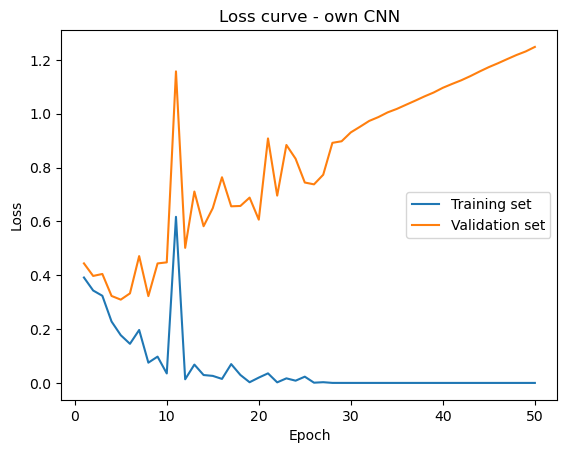

In [46]:
# Loss curve
epoch_no = [i for i in range(1,n_epochs+1)]

plt.plot(epoch_no,training_loss)
plt.plot(epoch_no,validation_loss)
plt.title('Loss curve - own CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(labels=['Training set','Validation set'])
plt.show()

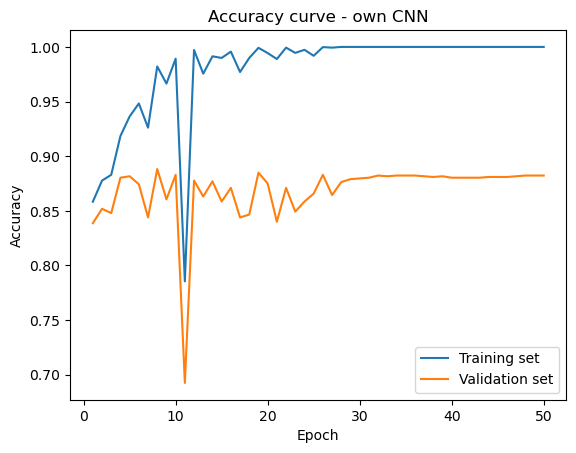

In [47]:
# accuracy curve
plt.plot(epoch_no,training_accuracy)
plt.plot(epoch_no,validation_accuracy)
plt.title('Accuracy curve - own CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(labels=['Training set','Validation set'])
plt.show()

## Interpretation - confusion matrix for own CNN
The model is able to segregate the majority of the images to its correct label except for the label 0 where the majority of the images are being predicted as label 1. False positives and false negatives are widely prevalent as well.

In [49]:
# confusion matrix on validation set
best_trained_model.eval()
best_trained_model = best_trained_model.to(device)

val_actual = []
val_preds = []
with torch.no_grad(): #deactivates gradient computation since we are evaluating the model on test data
    for batch_num, sample in enumerate(val_dataloader):
        data = sample['image'].to(device)
        output = best_trained_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        val_preds.append(pred.tolist()[0][0])
        val_actual.append(sample['label'].tolist()[0])

pd.DataFrame(confusion_matrix(val_actual,val_preds,labels=[0,1,2,3]))

,0,1,2,3
0,65,80,0,12
1,19,649,11,17
2,1,3,123,12
3,2,13,8,497


### Interpretability with Captum

* Integrated Gradients (estimates the importance of each pixel for prediction) - the heatmap is sparse with black patches indicating the important pixels. These, however are not entirely in line with the pink portion of the cell image which is important for classification.

* Gradient Shap (shows the actual contribution of each pixel for prediction) - the entire heatmap is more or less covered in black patches indicating that most of the pixels contributed equally.

* Occlusion (occluding the areas important for the classifier) - the top right and the bottom portions are highly occluded corresponding to the pink portions in the original image

In [51]:
# reading one of the images
img = Image.open('/kaggle/input/deep-learning-for-msc-2022-23/train/'+train_csv.iloc[val_dataset[0]['idx'],0])

In [53]:
transform = transforms.Compose([
 transforms.ToTensor()
])


transformed_img = transform(img)
input = transformed_img.unsqueeze(0)

In [54]:
#getting its prediction
output = best_trained_model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1) #returns k largest values of output along dimension 1

pred_label_idx.squeeze_()

tensor(1, device='cuda:0')

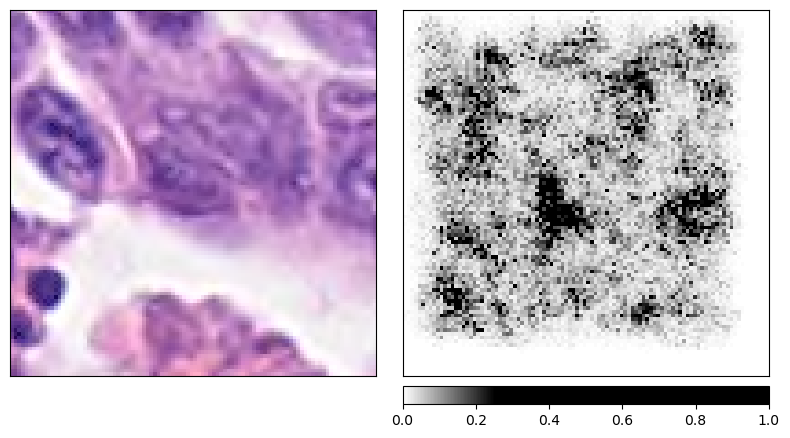

In [55]:
# Integrated Gradients with noise tunnel
integrated_gradients = IntegratedGradients(best_trained_model)
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig = noise_tunnel.attribute(input, target=pred_label_idx.to('cpu'), nt_samples=10, nt_type='smoothgrad_sq')

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

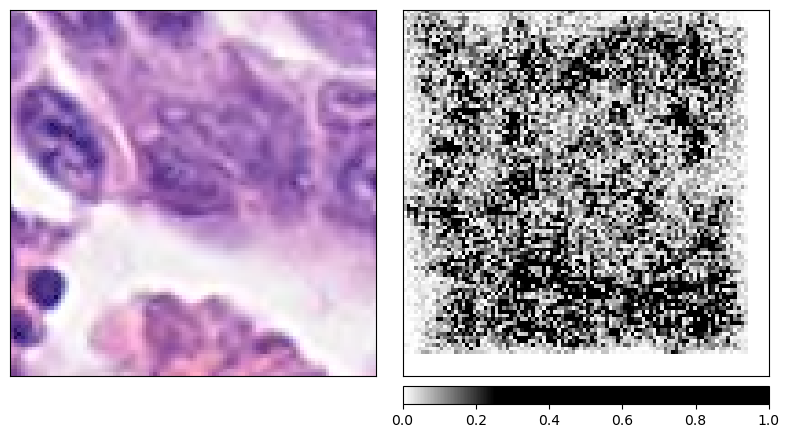

In [56]:
#Gradient Shap
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(best_trained_model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

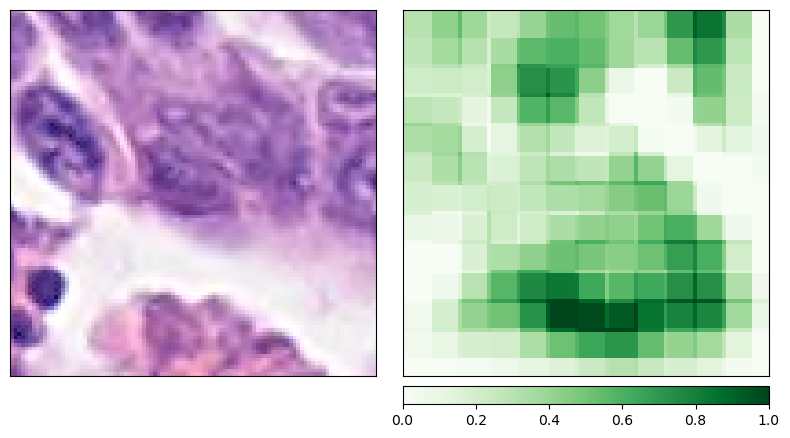

In [57]:
#Occlusion
occlusion = Occlusion(best_trained_model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### Test Data Predictions

In [58]:
# loading test dataset
cancer_test_dataset = CancerCellDataset(csv='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                  root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test',
                                  transform = transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(cancer_test_dataset)

In [59]:
# getting predictions on test data
best_trained_model.eval()
best_trained_model = best_trained_model.to(device)
test_preds = []
with torch.no_grad(): #deactivates gradient computation since we are evaluating the model on test data
    for batch_num, sample in enumerate(test_dataloader):
        data = sample['image'].to(device)
        output = best_trained_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        test_preds.append(pred.tolist()[0][0])
        
submissions = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
submissions['Label'] = test_preds
submissions.to_csv('submission.csv',index=False)

# Model 2 - pretrained ResNet model

I have fine-tuned the ResNet18 model by adding 3 fully-connected layers after the last layer, each of whose no. of neurons can be varied. ReLU activation is added after each fully-connected layer.

In [22]:
def train_pretrained_ConvNet(config, checkpoint_dir=None, data_dir=None):
    net = models.resnet18(pretrained=True)
    net.fc = nn.Sequential(
    nn.Linear(net.fc.in_features,config['l1']),
    nn.ReLU(),
    nn.Linear(config['l1'],config['l2']),
    nn.ReLU(),
    nn.Linear(config['l2'],config['l3']),
    nn.ReLU(),
    nn.Linear(config['l3'],len(train_csv.iloc[:,1].unique())))

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device) #assigning neural network to whichever device is available - cpu, gpu or multiple gpus

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    val_dataloader = DataLoader(
        val_dataset)

    n_epochs = 50

    training_loop(n_epochs,optimizer,net,device,criterion,train_dataloader, val_dataloader)
    print("Finished Training")

### Hyperparameter Tuning

In [23]:
num_samples = 10 # no. of hyperparameter sets to test
max_num_epochs = 2 # max no. of training iterations for each hyperparameter set
gpus_per_trial = 2

# hyperparameter search space
config = {
    'l1':tune.sample_from(lambda _: 2 ** np.random.randint(7,8+1)),
    'l2':tune.sample_from(lambda _: 2 ** np.random.randint(5,6+1)),
    'l3':tune.sample_from(lambda _: 2 ** np.random.randint(3,4+1)),
    'lr':tune.loguniform(1e-4,1e-2),
    'batch_size':tune.choice([16,32,64])
}
# scheduler for hyperparameter search
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

# reports the hyperparameter search results
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])

# runs the hyperparameter search
result = tune.run(
        train_pretrained_ConvNet,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

== Status ==
Current time: 2023-03-26 18:48:20 (running for 00:00:00.28)
Memory usage on this node: 4.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                           | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|--------------------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_pretrained_ConvNet_c70b9_00000 | RUNNING  | 172.19.2.2:54570 |           64 |  128 |   32 |   16 | 0.000189532 |
| train_pretrained_ConvNet_c70b9_00001 | PENDING  |                  |           

(train_pretrained_ConvNet pid=54570) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=54570)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=54570) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=54570)   warnings.warn(msg)
(train_pretrained_ConvNet pid=54570) Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/

== Status ==
Current time: 2023-03-26 18:48:31 (running for 00:00:11.31)
Memory usage on this node: 6.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                           | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|--------------------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_pretrained_ConvNet_c70b9_00000 | RUNNING  | 172.19.2.2:54570 |           64 |  128 |   32 |   16 | 0.000189532 |
| train_pretrained_ConvNet_c70b9_00001 | PENDING  |                  |           

(train_pretrained_ConvNet pid=54570) E0326 18:48:48.134897339   54605 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:48:51 (running for 00:00:31.36)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------------------+----------+------------------+--------------+------+------+------+-------------+
| Trial name                           | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |
|--------------------------------------+----------+------------------+--------------+------+------+------+-------------|
| train_pretrained_ConvNet_c70b9_00000 | RUNNING  | 172.19.2.2:54570 |           64 |  128 |   32 |   16 | 0.000189532 |
| train_pretrained_ConvNet_c70b9_00001 | PENDING  |                  |           

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_pretrained_ConvNet_c70b9_00000,0.771825,2023-03-26_18-50-03,True,,48551e3a7e024bb6bc57a5234959a71a,410e8f9ac071,2,0.597156,172.19.2.2,54570,97.5242,43.9595,97.5242,1679856603,0,,2,c70b9_00000,0.00522447
train_pretrained_ConvNet_c70b9_00001,0.859127,2023-03-26_18-51-44,True,,534ea34d13eb4ab0b442437e6a4f1eba,410e8f9ac071,2,0.345719,172.19.2.2,55844,95.3932,43.6685,95.3932,1679856704,0,,2,c70b9_00001,0.00482774
train_pretrained_ConvNet_c70b9_00002,0.786376,2023-03-26_18-52-43,True,,7b0429ea5f5540e892c7bacfa0cf8ca0,410e8f9ac071,1,0.800274,172.19.2.2,57110,51.774,51.774,51.774,1679856763,0,,1,c70b9_00002,0.005193
train_pretrained_ConvNet_c70b9_00003,0.847222,2023-03-26_18-53-41,True,,aa814c66e22946819a9e175a7ae839ea,410e8f9ac071,1,0.655565,172.19.2.2,57757,52.259,52.259,52.259,1679856821,0,,1,c70b9_00003,0.00583148
train_pretrained_ConvNet_c70b9_00004,0.590608,2023-03-26_18-54-46,True,,2c12832cdd6146929a571c4c94a0263b,410e8f9ac071,1,1.55806,172.19.2.2,58426,58.3399,58.3399,58.3399,1679856886,0,,1,c70b9_00004,0.00589919
train_pretrained_ConvNet_c70b9_00005,0.744709,2023-03-26_18-57-08,True,,43a1162269f44098842efddfd69b74e1,410e8f9ac071,2,0.68202,172.19.2.2,59451,135.44,63.2599,135.44,1679857028,0,,2,c70b9_00005,0.00575304
train_pretrained_ConvNet_c70b9_00006,0.740741,2023-03-26_18-58-05,True,,365f9485552540638c562466d88f4bac,410e8f9ac071,1,0.693232,172.19.2.2,63010,51.2563,51.2563,51.2563,1679857085,0,,1,c70b9_00006,0.00858426
train_pretrained_ConvNet_c70b9_00007,0.810847,2023-03-26_18-59-03,True,,417ffb374c434d4db32152eb5fc0387a,410e8f9ac071,1,0.838661,172.19.2.2,63673,51.2985,51.2985,51.2985,1679857143,0,,1,c70b9_00007,0.00504851
train_pretrained_ConvNet_c70b9_00008,0.580026,2023-03-26_19-00-07,True,,128b235c90ee46868f994cd67627b81c,410e8f9ac071,1,1.57676,172.19.2.2,64339,58.1385,58.1385,58.1385,1679857207,0,,1,c70b9_00008,0.00966787
train_pretrained_ConvNet_c70b9_00009,0.460317,2023-03-26_19-02-29,True,,c6244ede850742b09318518fdcf920d8,410e8f9ac071,2,1.18085,172.19.2.2,65390,135.818,64.1098,135.818,1679857349,0,,2,c70b9_00009,0.00526643


(train_pretrained_ConvNet pid=54570) 
(train_pretrained_ConvNet pid=54570) Validation set: Average loss: 0.3615, Accuracy: 1364/1512 (90%)
(train_pretrained_ConvNet pid=54570) 
== Status ==
Current time: 2023-03-26 18:49:24 (running for 00:01:04.88)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: -0.361504320294891
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------------------+----------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status   | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------------------

(train_pretrained_ConvNet pid=55844) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=55844)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=55844) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=55844)   warnings.warn(msg)
(train_pretrained_ConvNet pid=55844) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:50:14 (running for 00:01:54.63)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.361504320294891
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pret

(train_pretrained_ConvNet pid=55844) E0326 18:51:01.717628409   55879 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_pretrained_ConvNet pid=55844) E0326 18:51:01.811874542   55879 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:51:06 (running for 00:02:46.37)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.27208477262783637
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pr

(train_pretrained_ConvNet pid=57110) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=57110)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=57110) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=57110)   warnings.warn(msg)
(train_pretrained_ConvNet pid=57110) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:51:56 (running for 00:03:36.68)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.27208477262783637
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pr

(train_pretrained_ConvNet pid=57110) E0326 18:52:12.925309928   57150 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:52:16 (running for 00:03:56.73)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.27208477262783637
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pr

(train_pretrained_ConvNet pid=57757) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=57757)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=57757) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=57757)   warnings.warn(msg)
(train_pretrained_ConvNet pid=57757) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:52:54 (running for 00:04:34.72)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.361504320294891
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pret

(train_pretrained_ConvNet pid=58426) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=58426)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=58426) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=58426)   warnings.warn(msg)
(train_pretrained_ConvNet pid=58426) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:53:53 (running for 00:05:33.39)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.5085347610701498
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=58426) E0326 18:54:13.587613520   58460 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:54:18 (running for 00:05:58.48)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.5085347610701498
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=59451) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=59451)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=59451) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=59451)   warnings.warn(msg)
(train_pretrained_ConvNet pid=59451) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:54:57 (running for 00:06:37.80)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.6555652018454087
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=59451) E0326 18:55:27.122994092   59491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:55:27 (running for 00:07:07.89)
Memory usage on this node: 8.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.6555652018454087
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=59451) E0326 18:56:05.172641254   59491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:56:09 (running for 00:07:49.98)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 2.000: -0.4714373935251339 | Iter 1.000: -0.5085347610701498
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=63010) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=63010)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=63010) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=63010)   warnings.warn(msg)
(train_pretrained_ConvNet pid=63010) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:57:19 (running for 00:08:59.68)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.5085347610701498
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=63010) E0326 18:57:35.474612881   63051 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 18:57:39 (running for 00:09:19.75)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.5085347610701498
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=63673) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=63673)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=63673) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=63673)   warnings.warn(msg)
(train_pretrained_ConvNet pid=63673) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:58:17 (running for 00:09:57.40)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.6555652018454087
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pre

(train_pretrained_ConvNet pid=64339) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=64339)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=64339) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=64339)   warnings.warn(msg)
(train_pretrained_ConvNet pid=64339) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 18:59:14 (running for 00:10:54.66)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.674398571567998
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pret

(train_pretrained_ConvNet pid=65390) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_pretrained_ConvNet pid=65390)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(train_pretrained_ConvNet pid=65390) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(train_pretrained_ConvNet pid=65390)   warnings.warn(msg)
(train_pretrained_ConvNet pid=65390) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

== Status ==
Current time: 2023-03-26 19:00:18 (running for 00:11:58.65)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.6932319412905873
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pretrained_Con

(train_pretrained_ConvNet pid=65390) E0326 19:00:47.858677901   65425 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 19:00:48 (running for 00:12:28.75)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.6932319412905873
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pretrained_Con

(train_pretrained_ConvNet pid=65390) E0326 19:01:25.542004396   65425 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_pretrained_ConvNet pid=65390) E0326 19:01:25.594174347   65425 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_pretrained_ConvNet pid=65390) E0326 19:01:25.640931334   65425 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 19:01:30 (running for 00:13:10.37)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.674398571567998
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pretrained_Conv

(train_pretrained_ConvNet pid=65390) E0326 19:01:51.731455133   65425 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 19:01:55 (running for 00:13:35.45)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 2.000: -0.5971561051727992 | Iter 1.000: -0.674398571567998
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pretrained_Conv

2023-03-26 19:02:29,580	INFO tune.py:763 -- Total run time: 849.66 seconds (849.48 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 19:02:29 (running for 00:14:09.50)
Memory usage on this node: 8.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 2.000: -0.639587993446039 | Iter 1.000: -0.674398571567998
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_pretrained_ConvNet_2023-03-26_18-48-19
Number of trials: 10/10 (10 TERMINATED)
+--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------+
| Trial name                           | status     | loc              |   batch_size |   l1 |   l2 |   l3 |          lr |     loss |   accuracy |   training_iteration |
|--------------------------------------+------------+------------------+--------------+------+------+------+-------------+----------+------------+----------------------|
| train_pretrained_ConvNet_c70b9_0000

In [24]:
# printing the best hyperparameter results
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

Best trial config: {'l1': 128, 'l2': 64, 'l3': 16, 'lr': 0.00026914479633331214, 'batch_size': 64}
Best trial final validation loss: 0.3457186818774686
Best trial final validation accuracy: 0.8591269841269841


### Running the pre-trained ResNet with best hyperparameters

In [25]:
best_trained_model = models.resnet18(pretrained=True)
best_trained_model.fc = nn.Sequential(
    nn.Linear(best_trained_model.fc.in_features,best_trial.config['l1']),
    nn.ReLU(),
    nn.Linear(best_trial.config['l1'],best_trial.config['l2']),
    nn.ReLU(),
    nn.Linear(best_trial.config['l2'],best_trial.config['l3']),
    nn.ReLU(),
    nn.Linear(best_trial.config['l3'],len(train_csv.iloc[:,1].unique())))

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(best_trial.config["batch_size"]),
        shuffle=True,
        num_workers=2)
val_dataloader = DataLoader(
        val_dataset)

n_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_trained_model.parameters(), lr=best_trial.config["lr"])

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
training_loop(n_epochs,optimizer,best_trained_model,device,criterion,train_dataloader, val_dataloader)

E0326 19:04:01.407083356      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:04:01.457807271      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 1 ----------------------------



E0326 19:04:15.405413465      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:04:15.455810738      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.2522, Accuracy: 5758/6048 (95%)



2023-03-26 19:04:45,875	WARNING session.py:93 -- Session not detected. You should not be calling `report` outside `tuner.fit()` or while using the class API. 
2023-03-26 19:04:45,880	WARNING session.py:96 --   File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_o


Validation set: Average loss: 0.3071, Accuracy: 1415/1512 (94%)



E0326 19:04:45.889239410      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:04:45.988430076      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 2 ----------------------------



E0326 19:04:57.726645819      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:04:57.777145033      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.3376, Accuracy: 5522/6048 (91%)


Validation set: Average loss: 0.3767, Accuracy: 1350/1512 (89%)



E0326 19:05:27.720632369      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:05:27.770312159      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 3 ----------------------------



E0326 19:05:39.248795720      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:05:39.317758213      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.2628, Accuracy: 5382/6048 (89%)


Validation set: Average loss: 0.3171, Accuracy: 1318/1512 (87%)



E0326 19:06:09.483475603      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:06:09.559219400      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 4 ----------------------------



E0326 19:06:21.708725406      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:06:21.782966163      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0903, Accuracy: 5864/6048 (97%)


Validation set: Average loss: 0.1496, Accuracy: 1427/1512 (94%)



E0326 19:06:51.172756439      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:06:51.225175574      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 5 ----------------------------



E0326 19:07:03.442962523      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:07:03.518477671      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0969, Accuracy: 5904/6048 (98%)


Validation set: Average loss: 0.1498, Accuracy: 1445/1512 (96%)



E0326 19:07:34.115265508      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:07:34.166972541      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 6 ----------------------------



E0326 19:07:45.751219843      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:07:45.803400699      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.1142, Accuracy: 5828/6048 (96%)


Validation set: Average loss: 0.1735, Accuracy: 1421/1512 (94%)



E0326 19:08:16.211973770      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:08:16.265636466      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 7 ----------------------------



E0326 19:08:28.312917143      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:08:28.395317762      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0352, Accuracy: 5981/6048 (99%)


Validation set: Average loss: 0.1043, Accuracy: 1460/1512 (97%)



E0326 19:08:58.052341087      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:08:58.105054935      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 8 ----------------------------



E0326 19:09:10.750990546      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:09:10.799360742      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0254, Accuracy: 6003/6048 (99%)


Validation set: Average loss: 0.1066, Accuracy: 1458/1512 (96%)



E0326 19:09:41.288888825      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:09:41.341884350      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 9 ----------------------------



E0326 19:09:52.979163134      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:09:53.030876452      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0298, Accuracy: 5987/6048 (99%)


Validation set: Average loss: 0.1167, Accuracy: 1469/1512 (97%)



E0326 19:10:22.933084747      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:10:22.985681200      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 10 ----------------------------



E0326 19:10:34.167389769      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:10:34.215061483      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0092, Accuracy: 6028/6048 (100%)


Validation set: Average loss: 0.1124, Accuracy: 1469/1512 (97%)



E0326 19:11:03.925636778      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:11:03.979160994      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 11 ----------------------------



E0326 19:11:16.377824201      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:11:16.430125272      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0242, Accuracy: 6018/6048 (100%)


Validation set: Average loss: 0.0851, Accuracy: 1477/1512 (98%)



E0326 19:11:46.304130094      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:11:46.354570428      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 12 ----------------------------



E0326 19:11:57.692613115      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:11:57.743943264      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0332, Accuracy: 5997/6048 (99%)


Validation set: Average loss: 0.1475, Accuracy: 1451/1512 (96%)



E0326 19:12:27.954601502      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:12:28.005496290      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 13 ----------------------------



E0326 19:12:39.514590773      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:12:39.565705717      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.3160, Accuracy: 5519/6048 (91%)


Validation set: Average loss: 0.4776, Accuracy: 1346/1512 (89%)



E0326 19:13:09.965778135      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:13:10.018238605      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 14 ----------------------------



E0326 19:13:22.305990663      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:13:22.354665483      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0032, Accuracy: 6044/6048 (100%)


Validation set: Average loss: 0.0909, Accuracy: 1475/1512 (98%)



E0326 19:13:52.514779643      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:13:52.566986984      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 15 ----------------------------



E0326 19:14:04.059907793      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:14:04.111470925      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0028, Accuracy: 6046/6048 (100%)


Validation set: Average loss: 0.0822, Accuracy: 1483/1512 (98%)



E0326 19:14:33.847814341      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:14:33.899811708      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 16 ----------------------------



E0326 19:14:45.206349604      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:14:45.263985881      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0396, Accuracy: 5962/6048 (99%)


Validation set: Average loss: 0.3277, Accuracy: 1423/1512 (94%)



E0326 19:15:15.383672766      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:15:15.434664607      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 17 ----------------------------



E0326 19:15:27.578619459      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:15:27.628228940      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0126, Accuracy: 6029/6048 (100%)


Validation set: Average loss: 0.0914, Accuracy: 1463/1512 (97%)



E0326 19:15:57.506533785      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:15:57.560392587      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 18 ----------------------------



E0326 19:16:09.155420427      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:16:09.207120302      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0274, Accuracy: 5991/6048 (99%)


Validation set: Average loss: 0.1836, Accuracy: 1443/1512 (95%)



E0326 19:16:39.098776394      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:16:39.149362987      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 19 ----------------------------



E0326 19:16:50.556518841      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:16:50.605727577      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0058, Accuracy: 6038/6048 (100%)


Validation set: Average loss: 0.0955, Accuracy: 1464/1512 (97%)



E0326 19:17:20.700635348      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:17:20.752611614      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 20 ----------------------------



E0326 19:17:33.050598627      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:17:33.104208840      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0664, Accuracy: 5929/6048 (98%)


Validation set: Average loss: 0.2277, Accuracy: 1426/1512 (94%)



E0326 19:18:03.151916504      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:18:03.203680800      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 21 ----------------------------



E0326 19:18:14.847329825      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:18:14.896635050      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0844, Accuracy: 5893/6048 (97%)


Validation set: Average loss: 0.3410, Accuracy: 1402/1512 (93%)



E0326 19:18:44.900757898      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:18:44.953492529      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 22 ----------------------------



E0326 19:18:56.717962185      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:18:56.768813557      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0356, Accuracy: 5979/6048 (99%)


Validation set: Average loss: 0.2084, Accuracy: 1437/1512 (95%)



E0326 19:19:27.399987890      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:19:27.455028657      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 23 ----------------------------



E0326 19:19:39.624624782      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:19:39.672458133      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0021, Accuracy: 6044/6048 (100%)


Validation set: Average loss: 0.1177, Accuracy: 1472/1512 (97%)



E0326 19:20:09.648305113      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:20:09.702886366      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 24 ----------------------------



E0326 19:20:21.108265444      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:20:21.164053170      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0027, Accuracy: 6045/6048 (100%)


Validation set: Average loss: 0.1677, Accuracy: 1457/1512 (96%)



E0326 19:20:51.163541864      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:20:51.215117889      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 25 ----------------------------



E0326 19:21:02.854396282      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:21:02.904303344      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0116, Accuracy: 6025/6048 (100%)


Validation set: Average loss: 0.1053, Accuracy: 1470/1512 (97%)



E0326 19:21:33.479414055      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:21:33.548985661      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 26 ----------------------------



E0326 19:21:45.800830162      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:21:45.851660208      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0035, Accuracy: 6043/6048 (100%)


Validation set: Average loss: 0.1074, Accuracy: 1471/1512 (97%)



E0326 19:22:16.157301994      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:22:16.210225947      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 27 ----------------------------



E0326 19:22:27.687821152      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:22:27.736149510      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0068, Accuracy: 6033/6048 (100%)


Validation set: Average loss: 0.2046, Accuracy: 1452/1512 (96%)



E0326 19:22:57.825530531      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:22:57.877352670      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 28 ----------------------------



E0326 19:23:09.575943584      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:23:09.625099448      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0003, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1427, Accuracy: 1476/1512 (98%)



E0326 19:23:40.158337104      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:23:40.210718551      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 29 ----------------------------



E0326 19:23:52.463338291      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:23:52.511863763      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0462, Accuracy: 5961/6048 (99%)


Validation set: Average loss: 0.1650, Accuracy: 1435/1512 (95%)



E0326 19:24:22.545212321      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:24:22.596055645      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 30 ----------------------------



E0326 19:24:33.954010644      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:24:34.004480633      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0011, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1097, Accuracy: 1474/1512 (97%)



E0326 19:25:03.935033493      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:25:03.985823890      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 31 ----------------------------



E0326 19:25:15.524662636      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:25:15.577714781      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0004, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1117, Accuracy: 1482/1512 (98%)



E0326 19:25:45.517946237      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:25:45.569942275      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 32 ----------------------------



E0326 19:25:57.859628138      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:25:57.927794400      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0060, Accuracy: 6034/6048 (100%)


Validation set: Average loss: 0.1391, Accuracy: 1465/1512 (97%)



E0326 19:26:27.468228197      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 33 ----------------------------



E0326 19:26:39.649852289      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:26:39.701444511      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0008, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.0963, Accuracy: 1471/1512 (97%)



E0326 19:27:09.548713824      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:27:09.598368713      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 34 ----------------------------



E0326 19:27:21.028406004      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:27:21.086599826      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0398, Accuracy: 5992/6048 (99%)


Validation set: Average loss: 0.1782, Accuracy: 1429/1512 (95%)



E0326 19:27:51.266459810      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:27:51.322819493      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 35 ----------------------------



E0326 19:28:02.630590674      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:28:02.679992201      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0459, Accuracy: 5979/6048 (99%)


Validation set: Average loss: 0.2260, Accuracy: 1425/1512 (94%)



E0326 19:28:33.332739590      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:28:33.386105395      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 36 ----------------------------



E0326 19:28:45.338106876      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:28:45.389205610      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0017, Accuracy: 6045/6048 (100%)


Validation set: Average loss: 0.1638, Accuracy: 1459/1512 (96%)



E0326 19:29:16.004826446      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:29:16.055668804      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 37 ----------------------------



E0326 19:29:28.074758230      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:29:28.135312676      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0003, Accuracy: 6047/6048 (100%)


Validation set: Average loss: 0.1301, Accuracy: 1468/1512 (97%)



E0326 19:29:58.429136839      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:29:58.510939951      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 38 ----------------------------



E0326 19:30:10.435767168      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:30:10.590212233      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1367, Accuracy: 1473/1512 (97%)



E0326 19:30:40.692320986      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:30:40.748922913      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 39 ----------------------------



E0326 19:30:52.925765553      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:30:52.976030566      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1394, Accuracy: 1472/1512 (97%)



E0326 19:31:23.254963277      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:31:23.308445280      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 40 ----------------------------



E0326 19:31:35.247883829      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:31:35.299330210      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1384, Accuracy: 1473/1512 (97%)



E0326 19:32:05.434697084      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:32:05.487353901      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 41 ----------------------------



E0326 19:32:17.047707533      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:32:17.101719539      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1382, Accuracy: 1475/1512 (98%)



E0326 19:32:47.344271394      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:32:47.397650309      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 42 ----------------------------



E0326 19:32:59.651824842      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:32:59.705235991      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1387, Accuracy: 1476/1512 (98%)



E0326 19:33:30.228644583      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:33:30.281800594      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 43 ----------------------------



E0326 19:33:41.971847074      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1390, Accuracy: 1475/1512 (98%)



E0326 19:34:11.939125937      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:34:11.989298630      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 44 ----------------------------



E0326 19:34:23.762599582      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:34:23.849408034      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1396, Accuracy: 1474/1512 (97%)



E0326 19:34:53.666169685      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 45 ----------------------------



E0326 19:35:05.866950980      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:35:05.917079346      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1405, Accuracy: 1474/1512 (97%)



E0326 19:35:35.891466145      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:35:35.945621942      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 46 ----------------------------



E0326 19:35:47.118286766      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:35:47.167275118      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1412, Accuracy: 1474/1512 (97%)



E0326 19:36:17.243231305      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:36:17.297186453      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 47 ----------------------------



E0326 19:36:28.580817730      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:36:28.631131404      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1420, Accuracy: 1475/1512 (98%)



E0326 19:36:58.738910242      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:36:58.791505792      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 48 ----------------------------



E0326 19:37:10.941356876      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:37:10.989334327      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1428, Accuracy: 1476/1512 (98%)



E0326 19:37:40.680295536      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:37:40.730892331      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 49 ----------------------------



E0326 19:37:52.230557853      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:37:52.305536581      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1438, Accuracy: 1476/1512 (98%)



E0326 19:38:22.587371555      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:38:22.639957786      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


-----------------------------------Epoch 50 ----------------------------



E0326 19:38:33.939647936      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 19:38:33.991461166      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers



Training set: Average loss: 0.0000, Accuracy: 6048/6048 (100%)


Validation set: Average loss: 0.1446, Accuracy: 1476/1512 (98%)



## Interpretation - loss and accuracy curves for pretrained ResNet

The gap between the training and validation sets is much less compared to the previous CNN indicating less overfitting. In both the accuracy and loss curves, the values become almost constant after 40 epochs.

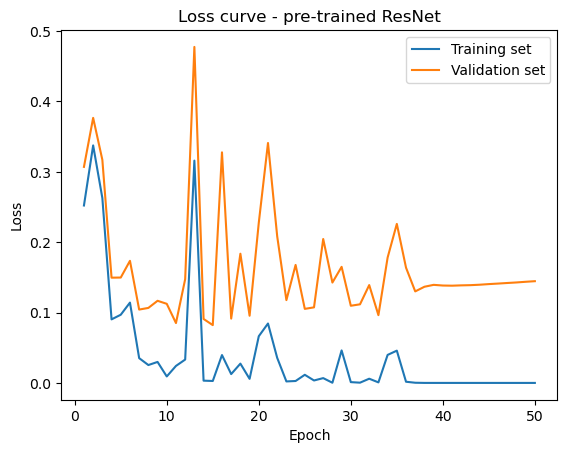

In [26]:
#loss curve
epoch_no = [i for i in range(1,n_epochs+1)]

plt.plot(epoch_no,training_loss)
plt.plot(epoch_no,validation_loss)
plt.title('Loss curve - pre-trained ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(labels=['Training set','Validation set'])
plt.show()

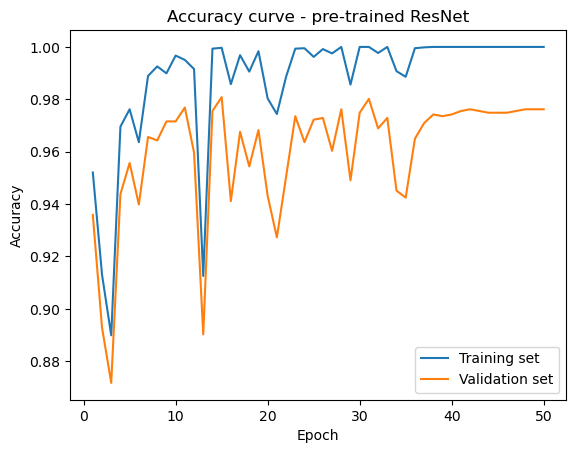

In [27]:
#accuracy curve
plt.plot(epoch_no,training_accuracy)
plt.plot(epoch_no,validation_accuracy)
plt.title('Accuracy curve - pre-trained ResNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(labels=['Training set','Validation set'])
plt.show()

## Interpretation - confusion matrix for pretrained ResNet

The majority of the images are segregated into their correct labels. The count of false positives and false negatives are less compared to the previous CNN as well.

In [28]:
#confusion matrix for validation data
best_trained_model = best_trained_model.to(device)
val_actual = []
val_preds = []
with torch.no_grad(): #deactivates gradient computation since we are evaluating the model on test data
    for batch_num, sample in enumerate(val_dataloader):
        data = sample['image'].to(device)
        output = best_trained_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        val_preds.append(pred.tolist()[0][0])
        val_actual.append(sample['label'].tolist()[0])

pd.DataFrame(confusion_matrix(val_actual,val_preds,labels=[0,1,2,3]))

,0,1,2,3
0,149,5,0,3
1,4,683,2,7
2,1,0,131,7
3,2,2,3,513


### Interpretability with Captum

* Integrated Gradients (estimates the importance of each pixel for prediction) - the heatmap shows black patches in the upper left corner of the image

* Gradient Shap (shows the actual contribution of each pixel for prediction) - the black patches are sparse and are in line with pink portions in the original image

* Occlusion (occluding the areas important for the classifier) - the highly occluded areas are more in line with the pink portions of the original image

In [32]:
# reading one of the images
img = Image.open('/kaggle/input/deep-learning-for-msc-2022-23/train/'+train_csv.iloc[val_dataset[0]['idx'],0])

In [33]:
transform = transforms.Compose([
 transforms.ToTensor()
])


transformed_img = transform(img)
input = transformed_img.unsqueeze(0)

In [34]:
#getting its prediction
output = best_trained_model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1) #returns k largest values of output along dimension 1

pred_label_idx.squeeze_()

tensor(2, device='cuda:0')

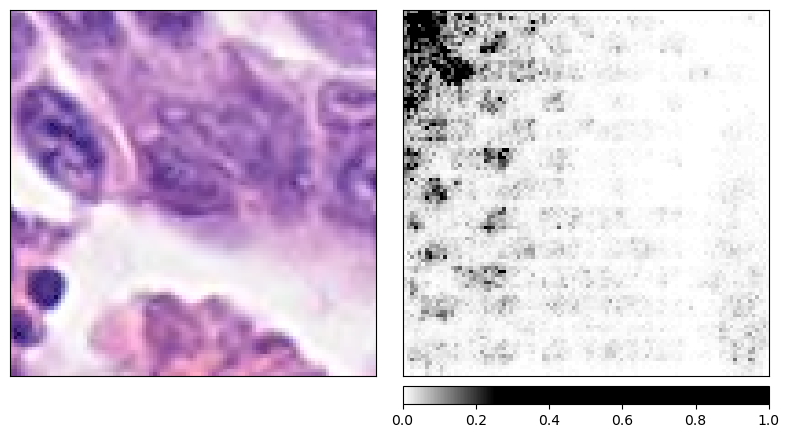

In [35]:
# Integrated Gradients with noise tunnel
integrated_gradients = IntegratedGradients(best_trained_model)
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig = noise_tunnel.attribute(input, target=pred_label_idx.to('cpu'), nt_samples=10, nt_type='smoothgrad_sq')

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

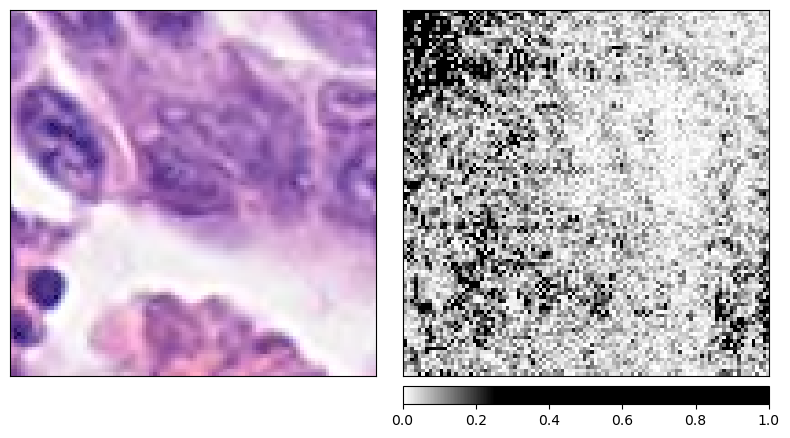

In [36]:
#Gradient Shap
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(best_trained_model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

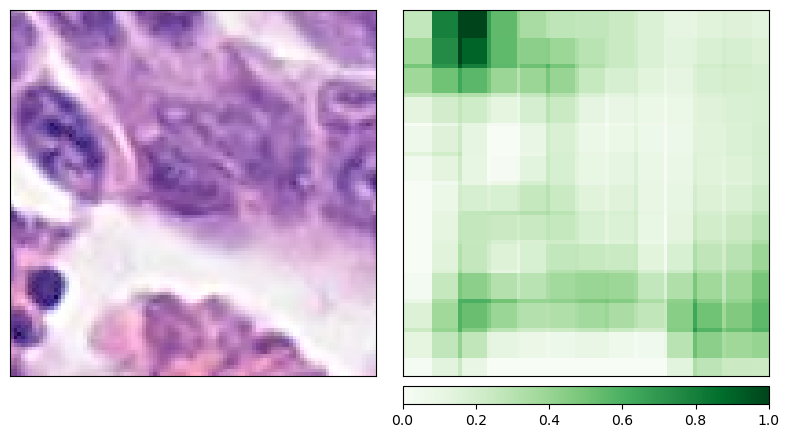

In [37]:
#Occlusion
occlusion = Occlusion(best_trained_model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### Test Data Predictions

In [39]:
# loading test dataset
cancer_test_dataset = CancerCellDataset(csv='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                  root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test',
                                  transform = transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(cancer_test_dataset)

In [40]:
# getting predictions on test data
best_trained_model.eval()
best_trained_model = best_trained_model.to(device)
test_preds = []
with torch.no_grad(): #deactivates gradient computation since we are evaluating the model on test data
    for batch_num, sample in enumerate(test_dataloader):
        data = sample['image'].to(device)
        output = best_trained_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        test_preds.append(pred.tolist()[0][0])
                
submissions = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
submissions['Label'] = test_preds
submissions.to_csv('submission.csv',index=False)

## Conclusion

The pretrained ResNet model is much better than the CNN constructed from scratch due to less overfitting, less prediction errors and better feature importances in the original image